# Problem 10.1

**Problem 10.1. Capacity and dispatch optimization in a network.**

**We build on the models described in Problems 8 and 9, however we add Denmark as a second node. Optimize the capacity and dispatch of solar PV, onshore wind, and Open Cycle Gas Turbine (OCGT) generators to supply the inelastic electricity demand throughout one year. 
To do this, take the time series for the wind and solar capacity factors for Portugal *and Denmark* in 2015 obtained from https://zenodo.org/record/3253876#.XSiVOEdS8l0
and https://zenodo.org/record/2613651#.X0kbhDVS-uV (select the file ‘pvoptimal.csv’) and  the electricity demand from https://github.com/martavp/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data.
Assume that methane gas emits 0.198 tCO2 per MWh of thermal energy contained in the gas. We assume the distance between the two nodes is 2477 km, the distance between Copenhagen and Lisbon.**






**For all of the following subproblems, always calculate the following values:** 
 - **Total system costs (in bn EUR)**
 - **Average electricity price (in EUR/MWh); number/share of hours with a price below 2 EUR/MWh**
 - **Congestion rent**
 - **Utilisation of transmission lines (in % of cap.)**
 - **Total generation per technology (in TWh)**
 - **Total CO2 emissions (in MtCO2)**


**a) Set up a network with two nodes and connect them with an overhead AC line (however, keep the capacity at 0 GW, and it cannot be extended).**

**b) Now assume the AC line connecting Portugal and Denmark has a capacity of 1 GW.**

**c) Now assume the AC line connecting Portugal and Denmark has a capacity of 10 GW.**

**d) Optimise the AC line capacity endogenously (assume it starts at 0 GW capacity).**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

Set parameter Username
Set parameter LicenseID to value 2767832
Academic license - for non-commercial use only - expires 2027-01-20


## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind, solar and OCGT

In [9]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

np.float64(101644.12332388277)

In [10]:
costs.at["solar", "capital_cost"] #EUR/MW/a

np.float64(51346.82981964593)

In [11]:
costs.at["OCGT", "capital_cost"] #EUR/MW/a

np.float64(47718.67056370105)

In [12]:
costs.at["OCGT", "marginal_cost"] #EUR/MWh

np.float64(64.6839512195122)

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [13]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [14]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal and Denmark in this excercise

In [15]:
countries = ['PRT', 'DNK']
coordinates = {'PRT': (38.74, -9.15), 'DNK': (55.67, 12.57)}

# a. Capacity and dispatch optimisation in a network, F = 0 GW

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity buses per country.

In [16]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )


In [18]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Add load to the buses.

In [19]:
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")

Add generators to the buses.

In [20]:
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

Add an overhead AC line between the buses with 0 MW capacity.

In [21]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
)

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x308d863c0>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x308d86510>},
 'flows': {}}

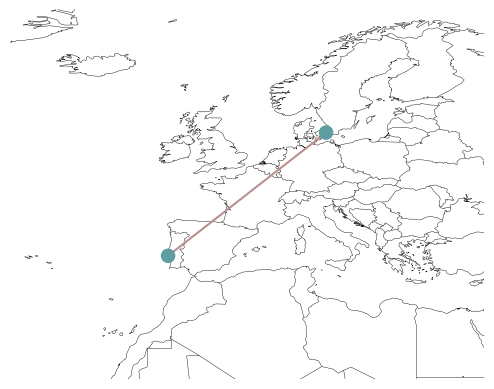

In [22]:
n.plot(bus_sizes=1, margin=1)

In [23]:
n.optimize(solver_name="gurobi")

Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 122.57it/s]
INFO:linopy.io: Writing time: 0.35s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-otw6tris.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-otw6tris.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 140166 rows, 61326 columns, 236551 nonzeros


INFO:gurobipy:obj: 140166 rows, 61326 columns, 236551 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros (Min)


Model fingerprint: 0x2610728d


INFO:gurobipy:Model fingerprint: 0x2610728d


Model has 52566 linear objective coefficients


INFO:gurobipy:Model has 52566 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 9e+03]


INFO:gurobipy:  RHS range        [2e+03, 9e+03]


Presolve removed 87556 rows and 26230 columns


INFO:gurobipy:Presolve removed 87556 rows and 26230 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 52610 rows, 35096 columns, 114005 nonzeros


INFO:gurobipy:Presolved: 52610 rows, 35096 columns, 114005 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 7.892e+04


INFO:gurobipy: AA' NZ     : 7.892e+04


 Factor NZ  : 2.544e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 2.544e+05 (roughly 40 MB of memory)


 Factor Ops : 1.325e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.325e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.46588478e+10 -3.70662960e+11  1.16e+05 2.03e-13  1.53e+08     0s


INFO:gurobipy:   0   5.46588478e+10 -3.70662960e+11  1.16e+05 2.03e-13  1.53e+08     0s


   1   1.00173309e+11 -4.81775490e+11  1.43e+04 6.38e+02  2.77e+07     0s


INFO:gurobipy:   1   1.00173309e+11 -4.81775490e+11  1.43e+04 6.38e+02  2.77e+07     0s


   2   9.16553033e+10 -1.97469164e+11  5.68e-10 1.21e+00  2.58e+06     0s


INFO:gurobipy:   2   9.16553033e+10 -1.97469164e+11  5.68e-10 1.21e+00  2.58e+06     0s


   3   1.94386009e+10 -1.92838349e+10  6.55e-11 1.22e-09  3.41e+05     0s


INFO:gurobipy:   3   1.94386009e+10 -1.92838349e+10  6.55e-11 1.22e-09  3.41e+05     0s


   4   9.84672045e+09 -5.33198343e+09  1.86e-11 7.86e-10  1.33e+05     0s


INFO:gurobipy:   4   9.84672045e+09 -5.33198343e+09  1.86e-11 7.86e-10  1.33e+05     0s


   5   8.59508822e+09 -7.62629932e+08  1.46e-11 5.82e-10  8.22e+04     0s


INFO:gurobipy:   5   8.59508822e+09 -7.62629932e+08  1.46e-11 5.82e-10  8.22e+04     0s


   6   7.64223940e+09  1.51736846e+09  7.31e-10 5.82e-10  5.38e+04     0s


INFO:gurobipy:   6   7.64223940e+09  1.51736846e+09  7.31e-10 5.82e-10  5.38e+04     0s


   7   6.54100664e+09  2.94577551e+09  3.64e-10 1.46e-10  3.16e+04     0s


INFO:gurobipy:   7   6.54100664e+09  2.94577551e+09  3.64e-10 1.46e-10  3.16e+04     0s


   8   5.93920735e+09  3.69895466e+09  2.56e-10 2.62e-10  1.97e+04     0s


INFO:gurobipy:   8   5.93920735e+09  3.69895466e+09  2.56e-10 2.62e-10  1.97e+04     0s


   9   5.66701376e+09  4.57644617e+09  1.78e-10 1.46e-10  9.57e+03     0s


INFO:gurobipy:   9   5.66701376e+09  4.57644617e+09  1.78e-10 1.46e-10  9.57e+03     0s


  10   5.50945025e+09  4.85752354e+09  3.57e-10 3.20e-10  5.72e+03     0s


INFO:gurobipy:  10   5.50945025e+09  4.85752354e+09  3.57e-10 3.20e-10  5.72e+03     0s


  11   5.40620944e+09  4.98268432e+09  5.02e-10 7.28e-10  3.72e+03     0s


INFO:gurobipy:  11   5.40620944e+09  4.98268432e+09  5.02e-10 7.28e-10  3.72e+03     0s


  12   5.35580066e+09  5.00777396e+09  1.08e-09 6.11e-10  3.05e+03     0s


INFO:gurobipy:  12   5.35580066e+09  5.00777396e+09  1.08e-09 6.11e-10  3.05e+03     0s


  13   5.33709085e+09  5.03544563e+09  1.41e-09 1.25e-09  2.65e+03     0s


INFO:gurobipy:  13   5.33709085e+09  5.03544563e+09  1.41e-09 1.25e-09  2.65e+03     0s


  14   5.30901486e+09  5.06530513e+09  1.18e-09 3.20e-10  2.14e+03     0s


INFO:gurobipy:  14   5.30901486e+09  5.06530513e+09  1.18e-09 3.20e-10  2.14e+03     0s


  15   5.25487020e+09  5.08419974e+09  7.79e-10 4.07e-10  1.50e+03     0s


INFO:gurobipy:  15   5.25487020e+09  5.08419974e+09  7.79e-10 4.07e-10  1.50e+03     0s


  16   5.22365376e+09  5.12498354e+09  8.97e-10 8.44e-10  8.66e+02     0s


INFO:gurobipy:  16   5.22365376e+09  5.12498354e+09  8.97e-10 8.44e-10  8.66e+02     0s


  17   5.21148387e+09  5.12887466e+09  6.69e-10 4.07e-10  7.25e+02     0s


INFO:gurobipy:  17   5.21148387e+09  5.12887466e+09  6.69e-10 4.07e-10  7.25e+02     0s


  18   5.19905794e+09  5.13388242e+09  2.95e-09 7.28e-10  5.72e+02     0s


INFO:gurobipy:  18   5.19905794e+09  5.13388242e+09  2.95e-09 7.28e-10  5.72e+02     0s


  19   5.19204502e+09  5.14006580e+09  2.32e-09 1.75e-10  4.56e+02     0s


INFO:gurobipy:  19   5.19204502e+09  5.14006580e+09  2.32e-09 1.75e-10  4.56e+02     0s


  20   5.18227131e+09  5.14874185e+09  2.49e-09 2.33e-10  2.94e+02     1s


INFO:gurobipy:  20   5.18227131e+09  5.14874185e+09  2.49e-09 2.33e-10  2.94e+02     1s


  21   5.17815390e+09  5.15693791e+09  2.13e-09 6.11e-10  1.86e+02     1s


INFO:gurobipy:  21   5.17815390e+09  5.15693791e+09  2.13e-09 6.11e-10  1.86e+02     1s


  22   5.17620616e+09  5.15824492e+09  1.85e-09 2.62e-10  1.58e+02     1s


INFO:gurobipy:  22   5.17620616e+09  5.15824492e+09  1.85e-09 2.62e-10  1.58e+02     1s


  23   5.17359874e+09  5.16016182e+09  4.01e-09 2.33e-10  1.18e+02     1s


INFO:gurobipy:  23   5.17359874e+09  5.16016182e+09  4.01e-09 2.33e-10  1.18e+02     1s


  24   5.17267149e+09  5.16362224e+09  2.55e-09 4.95e-10  7.94e+01     1s


INFO:gurobipy:  24   5.17267149e+09  5.16362224e+09  2.55e-09 4.95e-10  7.94e+01     1s


  25   5.17184861e+09  5.16517941e+09  3.13e-09 6.40e-10  5.85e+01     1s


INFO:gurobipy:  25   5.17184861e+09  5.16517941e+09  3.13e-09 6.40e-10  5.85e+01     1s


  26   5.17127805e+09  5.16559370e+09  4.23e-09 1.05e-09  4.99e+01     1s


INFO:gurobipy:  26   5.17127805e+09  5.16559370e+09  4.23e-09 1.05e-09  4.99e+01     1s


  27   5.17056184e+09  5.16635355e+09  1.77e-08 4.07e-10  3.69e+01     1s


INFO:gurobipy:  27   5.17056184e+09  5.16635355e+09  1.77e-08 4.07e-10  3.69e+01     1s


  28   5.17025817e+09  5.16730735e+09  2.15e-08 3.78e-10  2.59e+01     1s


INFO:gurobipy:  28   5.17025817e+09  5.16730735e+09  2.15e-08 3.78e-10  2.59e+01     1s


  29   5.17010663e+09  5.16790043e+09  1.36e-08 3.78e-10  1.94e+01     1s


INFO:gurobipy:  29   5.17010663e+09  5.16790043e+09  1.36e-08 3.78e-10  1.94e+01     1s


  30   5.17001154e+09  5.16801237e+09  1.13e-08 1.19e-09  1.75e+01     1s


INFO:gurobipy:  30   5.17001154e+09  5.16801237e+09  1.13e-08 1.19e-09  1.75e+01     1s


  31   5.16989172e+09  5.16836397e+09  9.36e-09 5.09e-11  1.34e+01     1s


INFO:gurobipy:  31   5.16989172e+09  5.16836397e+09  9.36e-09 5.09e-11  1.34e+01     1s


  32   5.16979485e+09  5.16863584e+09  6.59e-08 4.66e-10  1.02e+01     1s


INFO:gurobipy:  32   5.16979485e+09  5.16863584e+09  6.59e-08 4.66e-10  1.02e+01     1s


  33   5.16967184e+09  5.16884093e+09  4.48e-08 1.19e-09  7.29e+00     1s


INFO:gurobipy:  33   5.16967184e+09  5.16884093e+09  4.48e-08 1.19e-09  7.29e+00     1s


  34   5.16958491e+09  5.16905182e+09  3.07e-08 6.40e-10  4.68e+00     1s


INFO:gurobipy:  34   5.16958491e+09  5.16905182e+09  3.07e-08 6.40e-10  4.68e+00     1s


  35   5.16954503e+09  5.16926968e+09  1.07e-07 8.73e-10  2.42e+00     1s


INFO:gurobipy:  35   5.16954503e+09  5.16926968e+09  1.07e-07 8.73e-10  2.42e+00     1s


  36   5.16953946e+09  5.16928524e+09  2.36e-07 6.11e-10  2.23e+00     1s


INFO:gurobipy:  36   5.16953946e+09  5.16928524e+09  2.36e-07 6.11e-10  2.23e+00     1s


  37   5.16951416e+09  5.16938251e+09  2.02e-07 7.57e-10  1.16e+00     1s


INFO:gurobipy:  37   5.16951416e+09  5.16938251e+09  2.02e-07 7.57e-10  1.16e+00     1s


  38   5.16949557e+09  5.16946137e+09  1.40e-07 1.66e-09  3.00e-01     1s


INFO:gurobipy:  38   5.16949557e+09  5.16946137e+09  1.40e-07 1.66e-09  3.00e-01     1s


  39   5.16948777e+09  5.16947239e+09  3.91e-07 7.57e-10  1.35e-01     1s


INFO:gurobipy:  39   5.16948777e+09  5.16947239e+09  3.91e-07 7.57e-10  1.35e-01     1s


  40   5.16948404e+09  5.16947345e+09  2.70e-07 4.07e-10  9.29e-02     1s


INFO:gurobipy:  40   5.16948404e+09  5.16947345e+09  2.70e-07 4.07e-10  9.29e-02     1s


  41   5.16947621e+09  5.16947534e+09  1.19e-08 4.07e-10  7.65e-03     1s


INFO:gurobipy:  41   5.16947621e+09  5.16947534e+09  1.19e-08 4.07e-10  7.65e-03     1s


  42   5.16947582e+09  5.16947582e+09  2.36e-10 2.27e-09  4.25e-05     1s


INFO:gurobipy:  42   5.16947582e+09  5.16947582e+09  2.36e-10 2.27e-09  4.25e-05     1s


  43   5.16947582e+09  5.16947582e+09  7.37e-11 1.48e-09  1.35e-10     1s


INFO:gurobipy:  43   5.16947582e+09  5.16947582e+09  7.37e-11 1.48e-09  1.35e-10     1s


INFO:gurobipy:


Barrier solved model in 43 iterations and 0.98 seconds (0.81 work units)


INFO:gurobipy:Barrier solved model in 43 iterations and 0.98 seconds (0.81 work units)


Optimal objective 5.16947582e+09


INFO:gurobipy:Optimal objective 5.16947582e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


Crossover changed status from Optimal to Interrupted


INFO:gurobipy:Crossover changed status from Optimal to Interrupted


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   29492    5.1694758e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   29492    5.1694758e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 29492 iterations and 1.04 seconds (3.68 work units)


INFO:gurobipy:Solved in 29492 iterations and 1.04 seconds (3.68 work units)


Optimal objective  5.169475822e+09


INFO:gurobipy:Optimal objective  5.169475822e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61326 primals, 140166 duals
Objective: 5.17e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


('ok', 'optimal')

In [24]:
# Total system costs
n.objective/1e9

5.169475822317724

In [25]:
# Average electricity price
n.buses_t.marginal_price.mean()

name
PRT    61.105150
DNK    59.640202
dtype: float64

In [26]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

name
PRT    1244
DNK    1452
dtype: int64

In [27]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

name
PRT    0.142009
DNK    0.165753
dtype: float64

In [28]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(0.0)

In [29]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

name
PRT-DNK   NaN
dtype: float64

In [30]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT       16.0
     onwind     15.2
     solar       1.6
PRT  OCGT       27.0
     onwind      9.4
     solar      12.5
dtype: float64

In [31]:
n.generators.efficiency

name
PRT OCGT      0.41
PRT onwind    1.00
PRT solar     1.00
DNK OCGT      0.41
DNK onwind    1.00
DNK solar     1.00
Name: efficiency, dtype: float64

In [32]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(20729628.597112704)

# b. F = 1 GW

Repeat the same procedure as in a.

In [33]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )


Add the overhead AC line between the buses with 1 GW capacity.

In [34]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 1000,
    x = 1,
    r = 1,
)

In [35]:
n.optimize(solver_name="gurobi")

Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 137.10it/s]
INFO:linopy.io: Writing time: 0.2s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-qox7oyma.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-qox7oyma.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140166 rows, 61326 columns, 236551 nonzeros


INFO:gurobipy:obj: 140166 rows, 61326 columns, 236551 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros (Min)


Model fingerprint: 0xa670afd8


INFO:gurobipy:Model fingerprint: 0xa670afd8


Model has 52566 linear objective coefficients


INFO:gurobipy:Model has 52566 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+03, 9e+03]


INFO:gurobipy:  RHS range        [1e+03, 9e+03]


Presolve removed 78821 rows and 8735 columns


INFO:gurobipy:Presolve removed 78821 rows and 8735 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 61345 rows, 52591 columns, 148995 nonzeros


INFO:gurobipy:Presolved: 61345 rows, 52591 columns, 148995 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 9.641e+04


INFO:gurobipy: AA' NZ     : 9.641e+04


 Factor NZ  : 5.642e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 5.642e+05 (roughly 50 MB of memory)


 Factor Ops : 5.571e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.571e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.69032254e+10 -4.67469621e+10  4.54e+04 0.00e+00  1.66e+07     0s


INFO:gurobipy:   0   3.69032254e+10 -4.67469621e+10  4.54e+04 0.00e+00  1.66e+07     0s


   1   4.09409335e+10 -1.07093146e+11  3.77e+03 2.18e+02  2.93e+06     0s


INFO:gurobipy:   1   4.09409335e+10 -1.07093146e+11  3.77e+03 2.18e+02  2.93e+06     0s


   2   2.55520931e+10 -1.58805991e+10  3.20e-10 6.24e+00  3.13e+05     0s


INFO:gurobipy:   2   2.55520931e+10 -1.58805991e+10  3.20e-10 6.24e+00  3.13e+05     0s


   3   1.16019556e+10 -1.03665148e+09  9.00e-11 6.46e-01  8.96e+04     0s


INFO:gurobipy:   3   1.16019556e+10 -1.03665148e+09  9.00e-11 6.46e-01  8.96e+04     0s


   4   9.00074571e+09  6.16011452e+08  6.80e-11 4.69e-01  5.88e+04     0s


INFO:gurobipy:   4   9.00074571e+09  6.16011452e+08  6.80e-11 4.69e-01  5.88e+04     0s


   5   7.35858685e+09  1.81084301e+09  4.59e-11 3.96e-01  3.86e+04     0s


INFO:gurobipy:   5   7.35858685e+09  1.81084301e+09  4.59e-11 3.96e-01  3.86e+04     0s


   6   6.33968507e+09  2.73795791e+09  5.66e-11 2.52e-01  2.49e+04     0s


INFO:gurobipy:   6   6.33968507e+09  2.73795791e+09  5.66e-11 2.52e-01  2.49e+04     0s


   7   6.26202300e+09  3.37798786e+09  6.73e-11 1.64e-01  1.98e+04     0s


INFO:gurobipy:   7   6.26202300e+09  3.37798786e+09  6.73e-11 1.64e-01  1.98e+04     0s


   8   6.12060866e+09  3.55572950e+09  3.81e-09 1.65e-01  1.76e+04     0s


INFO:gurobipy:   8   6.12060866e+09  3.55572950e+09  3.81e-09 1.65e-01  1.76e+04     0s


   9   5.89133720e+09  3.79679906e+09  8.50e-09 1.05e-01  1.44e+04     0s


INFO:gurobipy:   9   5.89133720e+09  3.79679906e+09  8.50e-09 1.05e-01  1.44e+04     0s


  10   5.60340745e+09  4.29175282e+09  7.81e-09 4.50e-02  8.97e+03     0s


INFO:gurobipy:  10   5.60340745e+09  4.29175282e+09  7.81e-09 4.50e-02  8.97e+03     0s


  11   5.35550281e+09  4.60362065e+09  1.47e-08 3.69e-02  5.13e+03     0s


INFO:gurobipy:  11   5.35550281e+09  4.60362065e+09  1.47e-08 3.69e-02  5.13e+03     0s


  12   5.23979951e+09  4.77826178e+09  3.14e-08 2.19e-02  3.15e+03     0s


INFO:gurobipy:  12   5.23979951e+09  4.77826178e+09  3.14e-08 2.19e-02  3.15e+03     0s


  13   5.17411808e+09  4.82657502e+09  4.62e-08 1.75e-02  2.37e+03     0s


INFO:gurobipy:  13   5.17411808e+09  4.82657502e+09  4.62e-08 1.75e-02  2.37e+03     0s


  14   5.15205601e+09  4.86292976e+09  4.74e-08 1.39e-02  1.97e+03     0s


INFO:gurobipy:  14   5.15205601e+09  4.86292976e+09  4.74e-08 1.39e-02  1.97e+03     0s


  15   5.09132844e+09  4.90014650e+09  4.61e-08 1.02e-02  1.30e+03     1s


INFO:gurobipy:  15   5.09132844e+09  4.90014650e+09  4.61e-08 1.02e-02  1.30e+03     1s


  16   5.06117716e+09  4.94880536e+09  7.94e-08 5.16e-03  7.65e+02     1s


INFO:gurobipy:  16   5.06117716e+09  4.94880536e+09  7.94e-08 5.16e-03  7.65e+02     1s


  17   5.04329009e+09  4.96517846e+09  7.92e-08 3.58e-03  5.32e+02     1s


INFO:gurobipy:  17   5.04329009e+09  4.96517846e+09  7.92e-08 3.58e-03  5.32e+02     1s


  18   5.03113036e+09  4.97129205e+09  1.23e-07 3.00e-03  4.08e+02     1s


INFO:gurobipy:  18   5.03113036e+09  4.97129205e+09  1.23e-07 3.00e-03  4.08e+02     1s


  19   5.02135327e+09  4.97741753e+09  1.56e-07 2.42e-03  3.00e+02     1s


INFO:gurobipy:  19   5.02135327e+09  4.97741753e+09  1.56e-07 2.42e-03  3.00e+02     1s


  20   5.01660073e+09  4.98155209e+09  1.06e-07 2.04e-03  2.39e+02     1s


INFO:gurobipy:  20   5.01660073e+09  4.98155209e+09  1.06e-07 2.04e-03  2.39e+02     1s


  21   5.01139899e+09  4.98435343e+09  2.15e-07 1.77e-03  1.85e+02     1s


INFO:gurobipy:  21   5.01139899e+09  4.98435343e+09  2.15e-07 1.77e-03  1.85e+02     1s


  22   5.00931175e+09  4.99006277e+09  2.95e-07 1.24e-03  1.32e+02     1s


INFO:gurobipy:  22   5.00931175e+09  4.99006277e+09  2.95e-07 1.24e-03  1.32e+02     1s


  23   5.00805337e+09  4.99128506e+09  2.78e-07 1.13e-03  1.15e+02     1s


INFO:gurobipy:  23   5.00805337e+09  4.99128506e+09  2.78e-07 1.13e-03  1.15e+02     1s


  24   5.00706870e+09  4.99231207e+09  2.54e-07 1.03e-03  1.01e+02     1s


INFO:gurobipy:  24   5.00706870e+09  4.99231207e+09  2.54e-07 1.03e-03  1.01e+02     1s


  25   5.00649779e+09  4.99317112e+09  2.48e-07 9.48e-04  9.14e+01     1s


INFO:gurobipy:  25   5.00649779e+09  4.99317112e+09  2.48e-07 9.48e-04  9.14e+01     1s


  26   5.00573928e+09  4.99580951e+09  2.57e-07 6.94e-04  6.81e+01     1s


INFO:gurobipy:  26   5.00573928e+09  4.99580951e+09  2.57e-07 6.94e-04  6.81e+01     1s


  27   5.00533128e+09  4.99638388e+09  4.54e-07 6.40e-04  6.14e+01     1s


INFO:gurobipy:  27   5.00533128e+09  4.99638388e+09  4.54e-07 6.40e-04  6.14e+01     1s


  28   5.00510313e+09  4.99657375e+09  3.56e-07 6.22e-04  5.85e+01     1s


INFO:gurobipy:  28   5.00510313e+09  4.99657375e+09  3.56e-07 6.22e-04  5.85e+01     1s


  29   5.00479799e+09  4.99696311e+09  3.38e-07 5.83e-04  5.38e+01     1s


INFO:gurobipy:  29   5.00479799e+09  4.99696311e+09  3.38e-07 5.83e-04  5.38e+01     1s


  30   5.00462640e+09  4.99731721e+09  4.48e-07 5.49e-04  5.02e+01     1s


INFO:gurobipy:  30   5.00462640e+09  4.99731721e+09  4.48e-07 5.49e-04  5.02e+01     1s


  31   5.00448569e+09  4.99751938e+09  3.79e-07 5.30e-04  4.79e+01     1s


INFO:gurobipy:  31   5.00448569e+09  4.99751938e+09  3.79e-07 5.30e-04  4.79e+01     1s


  32   5.00426131e+09  4.99785436e+09  2.44e-07 4.97e-04  4.40e+01     1s


INFO:gurobipy:  32   5.00426131e+09  4.99785436e+09  2.44e-07 4.97e-04  4.40e+01     1s


  33   5.00416903e+09  4.99820416e+09  2.28e-07 4.63e-04  4.10e+01     1s


INFO:gurobipy:  33   5.00416903e+09  4.99820416e+09  2.28e-07 4.63e-04  4.10e+01     1s


  34   5.00389811e+09  4.99905986e+09  1.66e-07 3.80e-04  3.33e+01     1s


INFO:gurobipy:  34   5.00389811e+09  4.99905986e+09  1.66e-07 3.80e-04  3.33e+01     1s


  35   5.00367542e+09  5.00009027e+09  2.97e-07 2.27e-04  2.46e+01     1s


INFO:gurobipy:  35   5.00367542e+09  5.00009027e+09  2.97e-07 2.27e-04  2.46e+01     1s


  36   5.00349573e+09  5.00026542e+09  5.90e-05 2.13e-04  2.22e+01     1s


INFO:gurobipy:  36   5.00349573e+09  5.00026542e+09  5.90e-05 2.13e-04  2.22e+01     1s


  37   5.00342027e+09  5.00083219e+09  1.26e-04 1.66e-04  1.78e+01     1s


INFO:gurobipy:  37   5.00342027e+09  5.00083219e+09  1.26e-04 1.66e-04  1.78e+01     1s


  38   5.00339743e+09  5.00092004e+09  1.45e-04 1.59e-04  1.70e+01     1s


INFO:gurobipy:  38   5.00339743e+09  5.00092004e+09  1.45e-04 1.59e-04  1.70e+01     1s


  39   5.00328416e+09  5.00130718e+09  2.49e-04 1.28e-04  1.36e+01     1s


INFO:gurobipy:  39   5.00328416e+09  5.00130718e+09  2.49e-04 1.28e-04  1.36e+01     1s


  40   5.00325508e+09  5.00136165e+09  2.83e-04 1.23e-04  1.30e+01     1s


INFO:gurobipy:  40   5.00325508e+09  5.00136165e+09  2.83e-04 1.23e-04  1.30e+01     1s


  41   5.00321153e+09  5.00174191e+09  3.24e-04 9.19e-05  1.01e+01     1s


INFO:gurobipy:  41   5.00321153e+09  5.00174191e+09  3.24e-04 9.19e-05  1.01e+01     1s


  42   5.00319841e+09  5.00199854e+09  3.32e-04 6.37e-05  8.23e+00     1s


INFO:gurobipy:  42   5.00319841e+09  5.00199854e+09  3.32e-04 6.37e-05  8.23e+00     1s


  43   5.00307541e+09  5.00215639e+09  3.64e-04 5.12e-05  6.31e+00     1s


INFO:gurobipy:  43   5.00307541e+09  5.00215639e+09  3.64e-04 5.12e-05  6.31e+00     1s


  44   5.00303532e+09  5.00230958e+09  3.73e-04 3.51e-05  4.98e+00     1s


INFO:gurobipy:  44   5.00303532e+09  5.00230958e+09  3.73e-04 3.51e-05  4.98e+00     1s


  45   5.00299294e+09  5.00233712e+09  3.64e-04 3.33e-05  4.50e+00     1s


INFO:gurobipy:  45   5.00299294e+09  5.00233712e+09  3.64e-04 3.33e-05  4.50e+00     1s


  46   5.00292124e+09  5.00259355e+09  3.53e-04 1.01e-05  2.25e+00     1s


INFO:gurobipy:  46   5.00292124e+09  5.00259355e+09  3.53e-04 1.01e-05  2.25e+00     1s


  47   5.00291871e+09  5.00260517e+09  3.47e-04 9.63e-06  2.15e+00     1s


INFO:gurobipy:  47   5.00291871e+09  5.00260517e+09  3.47e-04 9.63e-06  2.15e+00     1s


  48   5.00291068e+09  5.00265136e+09  3.28e-04 6.13e-06  1.78e+00     1s


INFO:gurobipy:  48   5.00291068e+09  5.00265136e+09  3.28e-04 6.13e-06  1.78e+00     1s


  49   5.00290506e+09  5.00266568e+09  3.11e-04 5.65e-06  1.64e+00     1s


INFO:gurobipy:  49   5.00290506e+09  5.00266568e+09  3.11e-04 5.65e-06  1.64e+00     1s


  50   5.00289151e+09  5.00269598e+09  2.77e-04 4.64e-06  1.34e+00     1s


INFO:gurobipy:  50   5.00289151e+09  5.00269598e+09  2.77e-04 4.64e-06  1.34e+00     1s


  51   5.00288417e+09  5.00273051e+09  2.55e-04 2.76e-06  1.05e+00     1s


INFO:gurobipy:  51   5.00288417e+09  5.00273051e+09  2.55e-04 2.76e-06  1.05e+00     1s


  52   5.00287351e+09  5.00275671e+09  2.20e-04 2.03e-06  7.99e-01     1s


INFO:gurobipy:  52   5.00287351e+09  5.00275671e+09  2.20e-04 2.03e-06  7.99e-01     1s


  53   5.00287154e+09  5.00276749e+09  2.12e-04 1.74e-06  7.11e-01     1s


INFO:gurobipy:  53   5.00287154e+09  5.00276749e+09  2.12e-04 1.74e-06  7.11e-01     1s


  54   5.00285704e+09  5.00276913e+09  1.54e-04 1.68e-06  6.02e-01     1s


INFO:gurobipy:  54   5.00285704e+09  5.00276913e+09  1.54e-04 1.68e-06  6.02e-01     1s


  55   5.00283098e+09  5.00282687e+09  4.58e-05 5.24e-10  2.80e-02     1s


INFO:gurobipy:  55   5.00283098e+09  5.00282687e+09  4.58e-05 5.24e-10  2.80e-02     1s


  56   5.00283005e+09  5.00282983e+09  5.28e-06 1.02e-09  1.48e-03     1s


INFO:gurobipy:  56   5.00283005e+09  5.00282983e+09  5.28e-06 1.02e-09  1.48e-03     1s


  57   5.00282996e+09  5.00282996e+09  1.39e-08 4.37e-10  1.91e-06     1s


INFO:gurobipy:  57   5.00282996e+09  5.00282996e+09  1.39e-08 4.37e-10  1.91e-06     1s


  58   5.00282996e+09  5.00282996e+09  4.23e-09 5.24e-10  6.33e-12     1s


INFO:gurobipy:  58   5.00282996e+09  5.00282996e+09  4.23e-09 5.24e-10  6.33e-12     1s


INFO:gurobipy:


Barrier solved model in 58 iterations and 1.36 seconds (1.29 work units)


INFO:gurobipy:Barrier solved model in 58 iterations and 1.36 seconds (1.29 work units)


Optimal objective 5.00282996e+09


INFO:gurobipy:Optimal objective 5.00282996e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4407 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4407 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    7139 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    7139 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8538194e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8538194e-09      1s


INFO:gurobipy:


Crossover time: 0.10 seconds (0.06 work units)


INFO:gurobipy:Crossover time: 0.10 seconds (0.06 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11549    5.0028300e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   11549    5.0028300e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 11549 iterations and 1.51 seconds (1.39 work units)


INFO:gurobipy:Solved in 11549 iterations and 1.51 seconds (1.39 work units)


Optimal objective  5.002829957e+09


INFO:gurobipy:Optimal objective  5.002829957e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61326 primals, 140166 duals
Objective: 5.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


('ok', 'optimal')

In [36]:
# Total system costs
n.objective/1e9

5.0028299565370435

In [37]:
# Average electricity price
n.buses_t.marginal_price.mean()

name
PRT    61.053013
DNK    59.363296
dtype: float64

In [38]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

name
PRT    1254
DNK    1491
dtype: int64

In [39]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

name
PRT    0.143151
DNK    0.170205
dtype: float64

In [40]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(-100293619.69515777)

In [41]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

name
PRT-DNK    0.889298
dtype: float64

In [42]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        9.3
     onwind     18.4
     solar       0.0
PRT  OCGT       29.4
     onwind     11.1
     solar      13.6
dtype: float64

In [43]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(18675041.178988095)

# c. Unlimited F.
Assume F = 10 GW which is larger than maximal load in both countries.

In [44]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )


In [45]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 10000,
    x = 1,
    r = 1,
)

In [46]:
n.optimize(solver_name="gurobi")

Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 282.78it/s]
INFO:linopy.io: Writing time: 0.17s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-e0s361wc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-e0s361wc.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 140166 rows, 61326 columns, 236551 nonzeros


INFO:gurobipy:obj: 140166 rows, 61326 columns, 236551 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros (Min)


Model fingerprint: 0x09c93b86


INFO:gurobipy:Model fingerprint: 0x09c93b86


Model has 52566 linear objective coefficients


INFO:gurobipy:Model has 52566 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+04]


INFO:gurobipy:  RHS range        [2e+03, 1e+04]


Presolve removed 87581 rows and 17495 columns


INFO:gurobipy:Presolve removed 87581 rows and 17495 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52585 rows, 43831 columns, 131475 nonzeros


INFO:gurobipy:Presolved: 52585 rows, 43831 columns, 131475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 7.013e+04


INFO:gurobipy: AA' NZ     : 7.013e+04


 Factor NZ  : 3.188e+05 (roughly 34 MB of memory)


INFO:gurobipy: Factor NZ  : 3.188e+05 (roughly 34 MB of memory)


 Factor Ops : 2.502e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.502e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.35677064e+10  0.00000000e+00  9.32e+04 0.00e+00  2.57e+07     0s


INFO:gurobipy:   0   5.35677064e+10  0.00000000e+00  9.32e+04 0.00e+00  2.57e+07     0s


   1   7.18055530e+10 -6.14869369e+10  7.70e+03 3.49e+02  5.14e+06     0s


INFO:gurobipy:   1   7.18055530e+10 -6.14869369e+10  7.70e+03 3.49e+02  5.14e+06     0s


   2   4.47082187e+10 -1.42932200e+10  1.68e-09 6.78e+00  6.20e+05     0s


INFO:gurobipy:   2   4.47082187e+10 -1.42932200e+10  1.68e-09 6.78e+00  6.20e+05     0s


   3   1.69928130e+10 -1.02710038e+09  4.40e-10 9.39e-01  1.77e+05     0s


INFO:gurobipy:   3   1.69928130e+10 -1.02710038e+09  4.40e-10 9.39e-01  1.77e+05     0s


   4   1.10869909e+10  9.56030563e+08  2.41e-10 5.56e-01  9.84e+04     0s


INFO:gurobipy:   4   1.10869909e+10  9.56030563e+08  2.41e-10 5.56e-01  9.84e+04     0s


   5   8.78098305e+09  1.65413554e+09  1.60e-10 4.30e-01  6.90e+04     0s


INFO:gurobipy:   5   8.78098305e+09  1.65413554e+09  1.60e-10 4.30e-01  6.90e+04     0s


   6   7.88868412e+09  2.29103602e+09  3.74e-10 3.03e-01  5.40e+04     0s


INFO:gurobipy:   6   7.88868412e+09  2.29103602e+09  3.74e-10 3.03e-01  5.40e+04     0s


   7   7.64568598e+09  2.85509020e+09  6.17e-10 2.03e-01  4.61e+04     0s


INFO:gurobipy:   7   7.64568598e+09  2.85509020e+09  6.17e-10 2.03e-01  4.61e+04     0s


   8   6.92697085e+09  3.21323807e+09  1.86e-08 1.56e-01  3.57e+04     0s


INFO:gurobipy:   8   6.92697085e+09  3.21323807e+09  1.86e-08 1.56e-01  3.57e+04     0s


   9   6.74254729e+09  3.52248936e+09  1.87e-08 1.18e-01  3.09e+04     0s


INFO:gurobipy:   9   6.74254729e+09  3.52248936e+09  1.87e-08 1.18e-01  3.09e+04     0s


  10   6.00484988e+09  3.87858916e+09  2.51e-08 6.75e-02  2.04e+04     0s


INFO:gurobipy:  10   6.00484988e+09  3.87858916e+09  2.51e-08 6.75e-02  2.04e+04     0s


  11   5.66686952e+09  4.21140048e+09  2.87e-08 4.12e-02  1.39e+04     0s


INFO:gurobipy:  11   5.66686952e+09  4.21140048e+09  2.87e-08 4.12e-02  1.39e+04     0s


  12   5.43415306e+09  4.40991679e+09  1.68e-08 2.71e-02  9.80e+03     0s


INFO:gurobipy:  12   5.43415306e+09  4.40991679e+09  1.68e-08 2.71e-02  9.80e+03     0s


  13   5.29268716e+09  4.54480730e+09  2.97e-08 1.85e-02  7.15e+03     0s


INFO:gurobipy:  13   5.29268716e+09  4.54480730e+09  2.97e-08 1.85e-02  7.15e+03     0s


  14   5.16915079e+09  4.58304361e+09  2.62e-08 1.64e-02  5.61e+03     0s


INFO:gurobipy:  14   5.16915079e+09  4.58304361e+09  2.62e-08 1.64e-02  5.61e+03     0s


  15   5.10495113e+09  4.61557701e+09  3.12e-08 1.45e-02  4.68e+03     0s


INFO:gurobipy:  15   5.10495113e+09  4.61557701e+09  3.12e-08 1.45e-02  4.68e+03     0s


  16   5.03917152e+09  4.69566207e+09  6.24e-08 9.24e-03  3.29e+03     0s


INFO:gurobipy:  16   5.03917152e+09  4.69566207e+09  6.24e-08 9.24e-03  3.29e+03     0s


  17   4.99248942e+09  4.71960198e+09  8.06e-08 7.74e-03  2.61e+03     1s


INFO:gurobipy:  17   4.99248942e+09  4.71960198e+09  8.06e-08 7.74e-03  2.61e+03     1s


  18   4.97636788e+09  4.73119768e+09  1.07e-07 7.06e-03  2.35e+03     1s


INFO:gurobipy:  18   4.97636788e+09  4.73119768e+09  1.07e-07 7.06e-03  2.35e+03     1s


  19   4.95054656e+09  4.75813197e+09  4.00e-07 5.25e-03  1.84e+03     1s


INFO:gurobipy:  19   4.95054656e+09  4.75813197e+09  4.00e-07 5.25e-03  1.84e+03     1s


  20   4.94691945e+09  4.77293076e+09  3.74e-07 3.82e-03  1.66e+03     1s


INFO:gurobipy:  20   4.94691945e+09  4.77293076e+09  3.74e-07 3.82e-03  1.66e+03     1s


  21   4.89311899e+09  4.78779104e+09  7.95e-07 2.78e-03  1.01e+03     1s


INFO:gurobipy:  21   4.89311899e+09  4.78779104e+09  7.95e-07 2.78e-03  1.01e+03     1s


  22   4.87793614e+09  4.80072941e+09  1.73e-06 2.21e-03  7.41e+02     1s


INFO:gurobipy:  22   4.87793614e+09  4.80072941e+09  1.73e-06 2.21e-03  7.41e+02     1s


  23   4.86974987e+09  4.81030428e+09  1.03e-06 1.79e-03  5.70e+02     1s


INFO:gurobipy:  23   4.86974987e+09  4.81030428e+09  1.03e-06 1.79e-03  5.70e+02     1s


  24   4.86458528e+09  4.81834149e+09  1.47e-06 1.45e-03  4.44e+02     1s


INFO:gurobipy:  24   4.86458528e+09  4.81834149e+09  1.47e-06 1.45e-03  4.44e+02     1s


  25   4.86076096e+09  4.82977770e+09  1.54e-06 9.55e-04  2.97e+02     1s


INFO:gurobipy:  25   4.86076096e+09  4.82977770e+09  1.54e-06 9.55e-04  2.97e+02     1s


  26   4.85837538e+09  4.83492677e+09  8.72e-07 7.43e-04  2.25e+02     1s


INFO:gurobipy:  26   4.85837538e+09  4.83492677e+09  8.72e-07 7.43e-04  2.25e+02     1s


  27   4.85655938e+09  4.83741371e+09  4.96e-07 6.38e-04  1.84e+02     1s


INFO:gurobipy:  27   4.85655938e+09  4.83741371e+09  4.96e-07 6.38e-04  1.84e+02     1s


  28   4.85514803e+09  4.84020588e+09  8.43e-07 5.21e-04  1.44e+02     1s


INFO:gurobipy:  28   4.85514803e+09  4.84020588e+09  8.43e-07 5.21e-04  1.44e+02     1s


  29   4.85400102e+09  4.84484221e+09  5.26e-07 3.25e-04  8.81e+01     1s


INFO:gurobipy:  29   4.85400102e+09  4.84484221e+09  5.26e-07 3.25e-04  8.81e+01     1s


  30   4.85360032e+09  4.84617755e+09  4.44e-07 2.69e-04  7.14e+01     1s


INFO:gurobipy:  30   4.85360032e+09  4.84617755e+09  4.44e-07 2.69e-04  7.14e+01     1s


  31   4.85329453e+09  4.84673889e+09  4.67e-07 2.36e-04  6.31e+01     1s


INFO:gurobipy:  31   4.85329453e+09  4.84673889e+09  4.67e-07 2.36e-04  6.31e+01     1s


  32   4.85315955e+09  4.84785404e+09  6.06e-07 1.82e-04  5.11e+01     1s


INFO:gurobipy:  32   4.85315955e+09  4.84785404e+09  6.06e-07 1.82e-04  5.11e+01     1s


  33   4.85307304e+09  4.84851021e+09  6.27e-07 1.58e-04  4.39e+01     1s


INFO:gurobipy:  33   4.85307304e+09  4.84851021e+09  6.27e-07 1.58e-04  4.39e+01     1s


  34   4.85297888e+09  4.84910240e+09  1.11e-06 1.26e-04  3.73e+01     1s


INFO:gurobipy:  34   4.85297888e+09  4.84910240e+09  1.11e-06 1.26e-04  3.73e+01     1s


  35   4.85291819e+09  4.84944621e+09  8.63e-07 1.11e-04  3.34e+01     1s


INFO:gurobipy:  35   4.85291819e+09  4.84944621e+09  8.63e-07 1.11e-04  3.34e+01     1s


  36   4.85287948e+09  4.85041434e+09  1.06e-06 7.20e-05  2.37e+01     1s


INFO:gurobipy:  36   4.85287948e+09  4.85041434e+09  1.06e-06 7.20e-05  2.37e+01     1s


  37   4.85280425e+09  4.85067294e+09  2.63e-06 6.26e-05  2.05e+01     1s


INFO:gurobipy:  37   4.85280425e+09  4.85067294e+09  2.63e-06 6.26e-05  2.05e+01     1s


  38   4.85278953e+09  4.85124415e+09  1.53e-04 4.59e-05  1.49e+01     1s


INFO:gurobipy:  38   4.85278953e+09  4.85124415e+09  1.53e-04 4.59e-05  1.49e+01     1s


  39   4.85278097e+09  4.85133561e+09  1.99e-04 4.23e-05  1.39e+01     1s


INFO:gurobipy:  39   4.85278097e+09  4.85133561e+09  1.99e-04 4.23e-05  1.39e+01     1s


  40   4.85277868e+09  4.85154559e+09  2.11e-04 3.43e-05  1.19e+01     1s


INFO:gurobipy:  40   4.85277868e+09  4.85154559e+09  2.11e-04 3.43e-05  1.19e+01     1s


  41   4.85277888e+09  4.85165548e+09  2.24e-04 3.14e-05  1.08e+01     1s


INFO:gurobipy:  41   4.85277888e+09  4.85165548e+09  2.24e-04 3.14e-05  1.08e+01     1s


  42   4.85277253e+09  4.85193506e+09  2.29e-04 2.13e-05  8.07e+00     1s


INFO:gurobipy:  42   4.85277253e+09  4.85193506e+09  2.29e-04 2.13e-05  8.07e+00     1s


  43   4.85277283e+09  4.85246719e+09  1.94e-04 3.34e-06  2.94e+00     1s


INFO:gurobipy:  43   4.85277283e+09  4.85246719e+09  1.94e-04 3.34e-06  2.94e+00     1s


  44   4.85276472e+09  4.85274768e+09  7.07e-05 2.80e-10  1.63e-01     1s


INFO:gurobipy:  44   4.85276472e+09  4.85274768e+09  7.07e-05 2.80e-10  1.63e-01     1s


  45   4.85276349e+09  4.85276289e+09  5.66e-06 1.40e-09  5.77e-03     1s


INFO:gurobipy:  45   4.85276349e+09  4.85276289e+09  5.66e-06 1.40e-09  5.77e-03     1s


  46   4.85276339e+09  4.85276339e+09  5.74e-07 2.33e-10  1.72e-06     1s


INFO:gurobipy:  46   4.85276339e+09  4.85276339e+09  5.74e-07 2.33e-10  1.72e-06     1s


  47   4.85276339e+09  4.85276339e+09  2.84e-09 6.69e-10  1.81e-12     1s


INFO:gurobipy:  47   4.85276339e+09  4.85276339e+09  2.84e-09 6.69e-10  1.81e-12     1s


INFO:gurobipy:


Barrier solved model in 47 iterations and 1.03 seconds (0.84 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 1.03 seconds (0.84 work units)


Optimal objective 4.85276339e+09


INFO:gurobipy:Optimal objective 4.85276339e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4427 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4427 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    1790 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    1790 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.4184382e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.4184382e-10      1s


INFO:gurobipy:


Crossover time: 0.06 seconds (0.05 work units)


INFO:gurobipy:Crossover time: 0.06 seconds (0.05 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    6219    4.8527634e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    6219    4.8527634e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    8012 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8012 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5148721e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5148721e-09      1s


INFO:gurobipy:


Crossover time: 0.06 seconds (0.05 work units)


INFO:gurobipy:Crossover time: 0.06 seconds (0.05 work units)


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   14300    4.8527634e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   14300    4.8527634e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 14300 iterations and 1.19 seconds (0.99 work units)


INFO:gurobipy:Solved in 14300 iterations and 1.19 seconds (0.99 work units)


Optimal objective  4.852763389e+09


INFO:gurobipy:Optimal objective  4.852763389e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61326 primals, 140166 duals
Objective: 4.85e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


('ok', 'optimal')

In [47]:
# Total system costs
n.objective/1e9

4.852763388965552

In [48]:
# Average electricity price
n.buses_t.marginal_price.mean()

name
PRT    57.214036
DNK    57.214036
dtype: float64

In [49]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

name
PRT    1787
DNK    1787
dtype: int64

In [50]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

name
PRT    0.203995
DNK    0.203995
dtype: float64

In [51]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(0.0)

In [52]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

name
PRT-DNK    0.191488
dtype: float64

In [53]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        3.2
     onwind     24.8
     solar       0.0
PRT  OCGT       27.5
     onwind     11.9
     solar      14.3
dtype: float64

In [54]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(14834697.56278273)

# d. Optimise F endogenously (assume it starts at 0 GW capacity).

In [55]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )


In [56]:
costs.at["HVAC overhead", "capital_cost"]

np.float64(42.007473674372484)

In [57]:
costs.at["onwind", "capital_cost"]

np.float64(101644.12332388277)

Add captial costs and distance between the buses, and endogenise the capacity of the overhead AC line.

In [58]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
    s_nom_extendable = True
)

In [59]:
n.optimize(solver_name="gurobi")

Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 322.97it/s]
INFO:linopy.io: Writing time: 0.23s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-uxassduu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-uxassduu.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 140167 rows, 61327 columns, 254072 nonzeros


INFO:gurobipy:obj: 140167 rows, 61327 columns, 254072 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140167 rows, 61327 columns and 254072 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140167 rows, 61327 columns and 254072 nonzeros (Min)


Model fingerprint: 0x8395d133


INFO:gurobipy:Model fingerprint: 0x8395d133


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 9e+03]


INFO:gurobipy:  RHS range        [2e+03, 9e+03]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.20s


INFO:gurobipy:Presolve time: 0.20s


Presolved: 70105 rows, 43832 columns, 191955 nonzeros


INFO:gurobipy:Presolved: 70105 rows, 43832 columns, 191955 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 1.744e+05


INFO:gurobipy: AA' NZ     : 1.744e+05


 Factor NZ  : 7.483e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 7.483e+05 (roughly 50 MB of memory)


 Factor Ops : 8.510e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.510e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.74162353e+10  0.00000000e+00  9.69e+04 0.00e+00  2.08e+07     0s


INFO:gurobipy:   0   4.74162353e+10  0.00000000e+00  9.69e+04 0.00e+00  2.08e+07     0s


   1   5.72962595e+10 -7.59755270e+10  1.63e+04 2.65e+02  5.21e+06     0s


INFO:gurobipy:   1   5.72962595e+10 -7.59755270e+10  1.63e+04 2.65e+02  5.21e+06     0s


   2   4.07511813e+10 -3.44552017e+10  6.40e-10 4.83e+00  5.56e+05     0s


INFO:gurobipy:   2   4.07511813e+10 -3.44552017e+10  6.40e-10 4.83e+00  5.56e+05     0s


   3   1.24969540e+10 -9.17636724e+08  1.66e-10 2.75e-01  9.23e+04     0s


INFO:gurobipy:   3   1.24969540e+10 -9.17636724e+08  1.66e-10 2.75e-01  9.23e+04     0s


   4   7.97621588e+09  1.58008531e+09  7.28e-11 9.60e-02  4.35e+04     0s


INFO:gurobipy:   4   7.97621588e+09  1.58008531e+09  7.28e-11 9.60e-02  4.35e+04     0s


   5   7.03236504e+09  2.30239305e+09  5.09e-11 7.70e-02  3.21e+04     0s


INFO:gurobipy:   5   7.03236504e+09  2.30239305e+09  5.09e-11 7.70e-02  3.21e+04     0s


   6   6.98990268e+09  2.41435210e+09  5.09e-11 7.37e-02  3.10e+04     0s


INFO:gurobipy:   6   6.98990268e+09  2.41435210e+09  5.09e-11 7.37e-02  3.10e+04     0s


   7   6.80231225e+09  2.83242181e+09  8.73e-11 6.02e-02  2.69e+04     0s


INFO:gurobipy:   7   6.80231225e+09  2.83242181e+09  8.73e-11 6.02e-02  2.69e+04     0s


   8   6.15299644e+09  3.77387229e+09  6.99e-09 2.46e-02  1.61e+04     0s


INFO:gurobipy:   8   6.15299644e+09  3.77387229e+09  6.99e-09 2.46e-02  1.61e+04     0s


   9   5.86067534e+09  4.11415608e+09  3.18e-09 1.62e-02  1.18e+04     1s


INFO:gurobipy:   9   5.86067534e+09  4.11415608e+09  3.18e-09 1.62e-02  1.18e+04     1s


  10   5.55990825e+09  4.60073663e+09  5.09e-09 4.94e-03  6.47e+03     1s


INFO:gurobipy:  10   5.55990825e+09  4.60073663e+09  5.09e-09 4.94e-03  6.47e+03     1s


  11   5.43305626e+09  4.71349625e+09  7.69e-09 3.39e-03  4.85e+03     1s


INFO:gurobipy:  11   5.43305626e+09  4.71349625e+09  7.69e-09 3.39e-03  4.85e+03     1s


  12   5.36000388e+09  4.79794557e+09  7.12e-09 2.38e-03  3.79e+03     1s


INFO:gurobipy:  12   5.36000388e+09  4.79794557e+09  7.12e-09 2.38e-03  3.79e+03     1s


  13   5.29217666e+09  4.87997649e+09  8.36e-09 1.39e-03  2.78e+03     1s


INFO:gurobipy:  13   5.29217666e+09  4.87997649e+09  8.36e-09 1.39e-03  2.78e+03     1s


  14   5.23881707e+09  4.95639054e+09  1.37e-08 6.15e-04  1.90e+03     1s


INFO:gurobipy:  14   5.23881707e+09  4.95639054e+09  1.37e-08 6.15e-04  1.90e+03     1s


  15   5.20965030e+09  4.98740701e+09  2.36e-08 4.81e-04  1.50e+03     1s


INFO:gurobipy:  15   5.20965030e+09  4.98740701e+09  2.36e-08 4.81e-04  1.50e+03     1s


  16   5.18706084e+09  5.02447712e+09  1.70e-08 4.43e-04  1.10e+03     1s


INFO:gurobipy:  16   5.18706084e+09  5.02447712e+09  1.70e-08 4.43e-04  1.10e+03     1s


  17   5.16895631e+09  5.04686160e+09  1.30e-08 3.71e-04  8.22e+02     1s


INFO:gurobipy:  17   5.16895631e+09  5.04686160e+09  1.30e-08 3.71e-04  8.22e+02     1s


  18   5.15521217e+09  5.05217039e+09  9.27e-09 3.50e-04  6.94e+02     1s


INFO:gurobipy:  18   5.15521217e+09  5.05217039e+09  9.27e-09 3.50e-04  6.94e+02     1s


  19   5.14465599e+09  5.06860837e+09  1.16e-08 2.45e-04  5.12e+02     1s


INFO:gurobipy:  19   5.14465599e+09  5.06860837e+09  1.16e-08 2.45e-04  5.12e+02     1s


  20   5.13540944e+09  5.07253719e+09  3.37e-08 2.26e-04  4.24e+02     1s


INFO:gurobipy:  20   5.13540944e+09  5.07253719e+09  3.37e-08 2.26e-04  4.24e+02     1s


  21   5.13017518e+09  5.07637124e+09  1.79e-08 2.04e-04  3.62e+02     1s


INFO:gurobipy:  21   5.13017518e+09  5.07637124e+09  1.79e-08 2.04e-04  3.62e+02     1s


  22   5.12292050e+09  5.08065406e+09  6.92e-08 1.79e-04  2.85e+02     1s


INFO:gurobipy:  22   5.12292050e+09  5.08065406e+09  6.92e-08 1.79e-04  2.85e+02     1s


  23   5.11795300e+09  5.08522557e+09  9.73e-08 1.50e-04  2.21e+02     1s


INFO:gurobipy:  23   5.11795300e+09  5.08522557e+09  9.73e-08 1.50e-04  2.21e+02     1s


  24   5.11663186e+09  5.08710414e+09  9.56e-08 1.38e-04  1.99e+02     1s


INFO:gurobipy:  24   5.11663186e+09  5.08710414e+09  9.56e-08 1.38e-04  1.99e+02     1s


  25   5.11450133e+09  5.09207733e+09  1.64e-07 1.01e-04  1.51e+02     1s


INFO:gurobipy:  25   5.11450133e+09  5.09207733e+09  1.64e-07 1.01e-04  1.51e+02     1s


  26   5.11302319e+09  5.09290376e+09  1.70e-07 9.53e-05  1.36e+02     1s


INFO:gurobipy:  26   5.11302319e+09  5.09290376e+09  1.70e-07 9.53e-05  1.36e+02     1s


  27   5.11237519e+09  5.09371523e+09  2.20e-07 8.99e-05  1.26e+02     1s


INFO:gurobipy:  27   5.11237519e+09  5.09371523e+09  2.20e-07 8.99e-05  1.26e+02     1s


  28   5.11125954e+09  5.09715142e+09  2.63e-07 6.45e-05  9.51e+01     1s


INFO:gurobipy:  28   5.11125954e+09  5.09715142e+09  2.63e-07 6.45e-05  9.51e+01     1s


  29   5.11087291e+09  5.09757921e+09  2.02e-07 6.17e-05  8.96e+01     1s


INFO:gurobipy:  29   5.11087291e+09  5.09757921e+09  2.02e-07 6.17e-05  8.96e+01     1s


  30   5.11010107e+09  5.09785118e+09  4.07e-07 5.99e-05  8.26e+01     1s


INFO:gurobipy:  30   5.11010107e+09  5.09785118e+09  4.07e-07 5.99e-05  8.26e+01     1s


  31   5.10967198e+09  5.09849786e+09  4.32e-07 5.57e-05  7.54e+01     1s


INFO:gurobipy:  31   5.10967198e+09  5.09849786e+09  4.32e-07 5.57e-05  7.54e+01     1s


  32   5.10939154e+09  5.09907026e+09  3.46e-07 5.20e-05  6.96e+01     1s


INFO:gurobipy:  32   5.10939154e+09  5.09907026e+09  3.46e-07 5.20e-05  6.96e+01     1s


  33   5.10920716e+09  5.09934580e+09  3.69e-07 5.01e-05  6.65e+01     1s


INFO:gurobipy:  33   5.10920716e+09  5.09934580e+09  3.69e-07 5.01e-05  6.65e+01     1s


  34   5.10910926e+09  5.09982117e+09  3.76e-07 4.71e-05  6.26e+01     1s


INFO:gurobipy:  34   5.10910926e+09  5.09982117e+09  3.76e-07 4.71e-05  6.26e+01     1s


  35   5.10892493e+09  5.10037786e+09  2.84e-07 4.35e-05  5.76e+01     1s


INFO:gurobipy:  35   5.10892493e+09  5.10037786e+09  2.84e-07 4.35e-05  5.76e+01     1s


  36   5.10871557e+09  5.10072502e+09  4.29e-07 4.13e-05  5.39e+01     1s


INFO:gurobipy:  36   5.10871557e+09  5.10072502e+09  4.29e-07 4.13e-05  5.39e+01     1s


  37   5.10857307e+09  5.10122967e+09  5.00e-07 3.80e-05  4.95e+01     1s


INFO:gurobipy:  37   5.10857307e+09  5.10122967e+09  5.00e-07 3.80e-05  4.95e+01     1s


  38   5.10846403e+09  5.10144430e+09  5.57e-07 3.65e-05  4.74e+01     1s


INFO:gurobipy:  38   5.10846403e+09  5.10144430e+09  5.57e-07 3.65e-05  4.74e+01     1s


  39   5.10835048e+09  5.10189234e+09  4.51e-07 3.37e-05  4.36e+01     1s


INFO:gurobipy:  39   5.10835048e+09  5.10189234e+09  4.51e-07 3.37e-05  4.36e+01     1s


  40   5.10809251e+09  5.10233344e+09  1.47e-07 3.07e-05  3.89e+01     1s


INFO:gurobipy:  40   5.10809251e+09  5.10233344e+09  1.47e-07 3.07e-05  3.89e+01     1s


  41   5.10795016e+09  5.10266997e+09  2.34e-07 2.85e-05  3.56e+01     1s


INFO:gurobipy:  41   5.10795016e+09  5.10266997e+09  2.34e-07 2.85e-05  3.56e+01     1s


  42   5.10780695e+09  5.10303660e+09  3.89e-07 1.57e-05  3.22e+01     1s


INFO:gurobipy:  42   5.10780695e+09  5.10303660e+09  3.89e-07 1.57e-05  3.22e+01     1s


  43   5.10766504e+09  5.10331365e+09  5.20e-07 6.40e-06  2.94e+01     1s


INFO:gurobipy:  43   5.10766504e+09  5.10331365e+09  5.20e-07 6.40e-06  2.94e+01     1s


  44   5.10762093e+09  5.10337912e+09  4.01e-07 6.26e-06  2.86e+01     1s


INFO:gurobipy:  44   5.10762093e+09  5.10337912e+09  4.01e-07 6.26e-06  2.86e+01     1s


  45   5.10760972e+09  5.10355934e+09  3.96e-07 5.92e-06  2.73e+01     1s


INFO:gurobipy:  45   5.10760972e+09  5.10355934e+09  3.96e-07 5.92e-06  2.73e+01     1s


  46   5.10752274e+09  5.10377613e+09  3.84e-07 5.53e-06  2.53e+01     1s


INFO:gurobipy:  46   5.10752274e+09  5.10377613e+09  3.84e-07 5.53e-06  2.53e+01     1s


  47   5.10738408e+09  5.10420497e+09  6.30e-07 4.79e-06  2.15e+01     1s


INFO:gurobipy:  47   5.10738408e+09  5.10420497e+09  6.30e-07 4.79e-06  2.15e+01     1s


  48   5.10726389e+09  5.10446737e+09  5.00e-07 4.32e-06  1.89e+01     1s


INFO:gurobipy:  48   5.10726389e+09  5.10446737e+09  5.00e-07 4.32e-06  1.89e+01     1s


  49   5.10722448e+09  5.10492443e+09  5.64e-07 3.42e-06  1.55e+01     1s


INFO:gurobipy:  49   5.10722448e+09  5.10492443e+09  5.64e-07 3.42e-06  1.55e+01     1s


  50   5.10721177e+09  5.10497675e+09  5.92e-07 3.31e-06  1.51e+01     1s


INFO:gurobipy:  50   5.10721177e+09  5.10497675e+09  5.92e-07 3.31e-06  1.51e+01     1s


  51   5.10718342e+09  5.10503236e+09  6.12e-07 3.18e-06  1.45e+01     2s


INFO:gurobipy:  51   5.10718342e+09  5.10503236e+09  6.12e-07 3.18e-06  1.45e+01     2s


  52   5.10714797e+09  5.10517063e+09  5.30e-07 2.89e-06  1.33e+01     2s


INFO:gurobipy:  52   5.10714797e+09  5.10517063e+09  5.30e-07 2.89e-06  1.33e+01     2s


  53   5.10712232e+09  5.10530428e+09  5.46e-07 2.62e-06  1.23e+01     2s


INFO:gurobipy:  53   5.10712232e+09  5.10530428e+09  5.46e-07 2.62e-06  1.23e+01     2s


  54   5.10707097e+09  5.10536288e+09  5.25e-07 2.48e-06  1.15e+01     2s


INFO:gurobipy:  54   5.10707097e+09  5.10536288e+09  5.25e-07 2.48e-06  1.15e+01     2s


  55   5.10705132e+09  5.10556729e+09  3.65e-07 2.09e-06  1.00e+01     2s


INFO:gurobipy:  55   5.10705132e+09  5.10556729e+09  3.65e-07 2.09e-06  1.00e+01     2s


  56   5.10691121e+09  5.10565063e+09  8.47e-07 6.98e-10  8.51e+00     2s


INFO:gurobipy:  56   5.10691121e+09  5.10565063e+09  8.47e-07 6.98e-10  8.51e+00     2s


  57   5.10689214e+09  5.10598786e+09  6.62e-07 1.35e-09  6.10e+00     2s


INFO:gurobipy:  57   5.10689214e+09  5.10598786e+09  6.62e-07 1.35e-09  6.10e+00     2s


  58   5.10685732e+09  5.10602341e+09  8.06e-07 1.28e-09  5.63e+00     2s


INFO:gurobipy:  58   5.10685732e+09  5.10602341e+09  8.06e-07 1.28e-09  5.63e+00     2s


  59   5.10684874e+09  5.10610799e+09  1.01e-05 4.47e-10  5.00e+00     2s


INFO:gurobipy:  59   5.10684874e+09  5.10610799e+09  1.01e-05 4.47e-10  5.00e+00     2s


  60   5.10683153e+09  5.10623271e+09  3.37e-05 1.08e-09  4.04e+00     2s


INFO:gurobipy:  60   5.10683153e+09  5.10623271e+09  3.37e-05 1.08e-09  4.04e+00     2s


  61   5.10680622e+09  5.10632886e+09  7.38e-05 5.53e-10  3.22e+00     2s


INFO:gurobipy:  61   5.10680622e+09  5.10632886e+09  7.38e-05 5.53e-10  3.22e+00     2s


  62   5.10679997e+09  5.10637876e+09  8.62e-05 2.62e-10  2.84e+00     2s


INFO:gurobipy:  62   5.10679997e+09  5.10637876e+09  8.62e-05 2.62e-10  2.84e+00     2s


  63   5.10677936e+09  5.10652031e+09  1.20e-04 5.77e-09  1.75e+00     2s


INFO:gurobipy:  63   5.10677936e+09  5.10652031e+09  1.20e-04 5.77e-09  1.75e+00     2s


  64   5.10675011e+09  5.10667756e+09  7.87e-05 3.93e-09  4.87e-01     2s


INFO:gurobipy:  64   5.10675011e+09  5.10667756e+09  7.87e-05 3.93e-09  4.87e-01     2s


  65   5.10673448e+09  5.10668325e+09  5.92e-05 3.29e-09  3.44e-01     2s


INFO:gurobipy:  65   5.10673448e+09  5.10668325e+09  5.92e-05 3.29e-09  3.44e-01     2s


  66   5.10672781e+09  5.10668423e+09  4.92e-05 2.99e-09  2.93e-01     2s


INFO:gurobipy:  66   5.10672781e+09  5.10668423e+09  4.92e-05 2.99e-09  2.93e-01     2s


  67   5.10671374e+09  5.10668669e+09  3.09e-05 2.00e-09  1.82e-01     2s


INFO:gurobipy:  67   5.10671374e+09  5.10668669e+09  3.09e-05 2.00e-09  1.82e-01     2s


  68   5.10671324e+09  5.10668783e+09  3.02e-05 1.72e-09  1.71e-01     2s


INFO:gurobipy:  68   5.10671324e+09  5.10668783e+09  3.02e-05 1.72e-09  1.71e-01     2s


  69   5.10670762e+09  5.10668859e+09  2.24e-05 6.98e-10  1.28e-01     2s


INFO:gurobipy:  69   5.10670762e+09  5.10668859e+09  2.24e-05 6.98e-10  1.28e-01     2s


  70   5.10669525e+09  5.10669341e+09  5.14e-06 1.99e-09  1.24e-02     2s


INFO:gurobipy:  70   5.10669525e+09  5.10669341e+09  5.14e-06 1.99e-09  1.24e-02     2s


  71   5.10669373e+09  5.10669368e+09  3.51e-08 7.57e-10  3.03e-04     2s


INFO:gurobipy:  71   5.10669373e+09  5.10669368e+09  3.51e-08 7.57e-10  3.03e-04     2s


  72   5.10669371e+09  5.10669371e+09  8.49e-10 3.75e-09  4.30e-09     2s


INFO:gurobipy:  72   5.10669371e+09  5.10669371e+09  8.49e-10 3.75e-09  4.30e-09     2s


INFO:gurobipy:


Barrier solved model in 72 iterations and 2.02 seconds (2.03 work units)


INFO:gurobipy:Barrier solved model in 72 iterations and 2.02 seconds (2.03 work units)


Optimal objective 5.10669371e+09


INFO:gurobipy:Optimal objective 5.10669371e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4432 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    4432 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


    7072 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    7072 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0000895e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0000895e-09      2s


INFO:gurobipy:


Crossover time: 0.08 seconds (0.08 work units)


INFO:gurobipy:Crossover time: 0.08 seconds (0.08 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11507    5.1066937e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   11507    5.1066937e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 11507 iterations and 2.14 seconds (2.15 work units)


INFO:gurobipy:Solved in 11507 iterations and 2.14 seconds (2.15 work units)


Optimal objective  5.106693708e+09


INFO:gurobipy:Optimal objective  5.106693708e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140167 duals
Objective: 5.11e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.


('ok', 'optimal')

In [60]:
# Total system costs
n.objective/1e9

5.106693707557571

In [61]:
# Average electricity price
n.buses_t.marginal_price.mean()

name
PRT    61.081714
DNK    59.417098
dtype: float64

In [62]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

name
PRT    1250
DNK    1483
dtype: int64

In [63]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

name
PRT    0.142694
DNK    0.169292
dtype: float64

In [64]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(-93730605.83284725)

In [65]:
n.lines_t.p0["PRT-DNK"] * n.lines_t.p0["PRT-DNK"]

snapshot
2015-01-01 00:00:00    128100.934790
2015-01-01 01:00:00    257722.952776
2015-01-01 02:00:00    530208.540960
2015-01-01 03:00:00    811442.419235
2015-01-01 04:00:00    811442.419235
                           ...      
2015-12-31 19:00:00    811442.419235
2015-12-31 20:00:00    811442.419235
2015-12-31 21:00:00    811442.419235
2015-12-31 22:00:00    811442.419235
2015-12-31 23:00:00    811442.419235
Name: PRT-DNK, Length: 8760, dtype: float64

In [66]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

name
PRT-DNK    0.854408
dtype: float64

In [67]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT       10.3
     onwind     18.4
     solar       0.0
PRT  OCGT       28.8
     onwind     10.7
     solar      13.5
dtype: float64

In [68]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(18886469.938808523)